In [1]:
%autosave 300
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch


In [22]:
from src.helper import set_seed, plot_loss_accuracy, get_device
from src.preprocessing import data_augmentations
from src.dataloader import get_data_loader
from src.paper_nets.resnet import ResNetX
from src.trainer import (
    train_module,
    test_module,
    model_drivers,
    suggested_lr,
    get_lr_scheduler,
)
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchinfo import summary
from torchview import draw_graph
import torchvision
from src.utils import imshow
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
import seaborn as sns
import torch

In [4]:
# Setting up basic training elements
set_seed(42)
device = get_device()
print(device)
batch_size = 512
epochs = 25
learning_rate = 0.005

Random seed set as 42
cuda


## DataPrep

In [5]:
# Specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
num_classes = len(classes)

In [6]:
# get CIFAR10 data from torchvision
# downloading train and test data
train = datasets.CIFAR10("./data", train=True, download=True)
test = datasets.CIFAR10("./data", train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# get dataloader for data batching
dataloader_args = (
    dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
    if device.type == "cuda"
    else dict(shuffle=True, batch_size=batch_size)
)

# get train and test transformations
train_transforms, test_transforms = data_augmentations()

# batch loading
train_dataset, train_loader, test_dataset, test_loader = get_data_loader(
    train, test, train_transforms, test_transforms, dataloader_args
)

In [16]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    print(images.mean())
    print(images.std())
    break

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([512, 3, 32, 32])
torch.Size([512])
tensor(0.0768)
tensor(0.9691)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


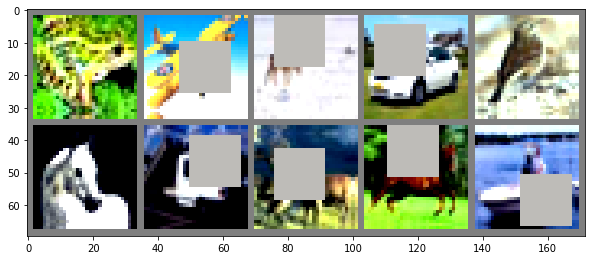

In [27]:
plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(images[:10], nrow=5))

## Paper Resnet Model

In [30]:
model_parameters = {}
model_parameters["resnet18"] = ([64, 128, 256, 512], [2, 2, 2, 2], 1, False)
model_parameters["resnet34"] = ([64, 128, 256, 512], [3, 4, 6, 3], 1, False)
model_parameters["resnet50"] = ([64, 128, 256, 512], [3, 4, 6, 3], 4, True)
model_parameters["resnet101"] = ([64, 128, 256, 512], [3, 4, 23, 3], 4, True)
model_parameters["resnet152"] = ([64, 128, 256, 512], [3, 8, 36, 3], 4, True)

### Resnet-34

In [11]:
resnet_model = ResNetX(
    resnet_variant=model_parameters["resnet34"], img_channels=3, num_classes=10
).to(device)
print(resnet_model)

ResNetX(
  (prep_layer): ResnetPrepBlock(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (layer1): Sequential(
    (0): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [12]:
summary(resnet_model, (1,3, 32,32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetX                                  [1, 10]                   --
├─ResnetPrepBlock: 1-1                   [1, 64, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 16, 16]           128
│    └─ReLU: 2-3                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                    [1, 64, 8, 8]             --
├─Sequential: 1-2                        [1, 64, 8, 8]             --
│    └─ResnetBasicBlock: 2-5             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│

In [13]:
optimizer, criterion, metric, early_stopping = model_drivers(
    model=resnet_model,
    learning_rate=learning_rate,
    device=device,
    num_classes=num_classes,
    model_name="resnet_model_34.pt",
)

In [14]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        resnet_model,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        resnet_model,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )


    early_stopping(
        test_losses[-1], resnet_model, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


training:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/98 [00:00<?, ?it/s]

Avg Train Loss: 2.105160174321155 Avg Train Metric: 0.18040920946062827: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.35it/s]


Validation loss decreased (inf --> 1.783935).  Saving model ...
Epoch 1


Avg Train Loss: 1.711682076356849 Avg Train Metric: 0.34443540445395876: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.28it/s]


EarlyStopping counter: 1 out of 5
Epoch 2


Avg Train Loss: 1.5527794908504098 Avg Train Metric: 0.42738310384507083: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.23it/s]


EarlyStopping counter: 2 out of 5
Epoch 3


Avg Train Loss: 1.4711270794576528 Avg Train Metric: 0.4788043617593999: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:12<00:00,  8.16it/s]


Validation loss decreased (1.783935 --> 1.581042).  Saving model ...
Epoch 4


Avg Train Loss: 1.3079026268453013 Avg Train Metric: 0.5125992815105282: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.19it/s]


Validation loss decreased (1.581042 --> 1.215944).  Saving model ...
Epoch 5


Avg Train Loss: 1.2673687436142747 Avg Train Metric: 0.5630440608579286: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.19it/s]


EarlyStopping counter: 1 out of 5
Epoch 6


Avg Train Loss: 1.1723218207456627 Avg Train Metric: 0.5725444372819395: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.64it/s]


Validation loss decreased (1.215944 --> 1.203081).  Saving model ...
Epoch 7


Avg Train Loss: 1.0753460684601142 Avg Train Metric: 0.6132328850882394: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.26it/s]


Validation loss decreased (1.203081 --> 1.028837).  Saving model ...
Epoch 8


Avg Train Loss: 1.0086715409950333 Avg Train Metric: 0.6392170251632223: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.17it/s]


Validation loss decreased (1.028837 --> 0.907671).  Saving model ...
Epoch 9


Avg Train Loss: 0.9670778306163087 Avg Train Metric: 0.655066371572261: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.26it/s]


EarlyStopping counter: 1 out of 5
Epoch 10


Avg Train Loss: 0.9241982442992074 Avg Train Metric: 0.668666063522806: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.15it/s]


Validation loss decreased (0.907671 --> 0.871506).  Saving model ...
Epoch 11


Avg Train Loss: 0.8857400995128009 Avg Train Metric: 0.6856565566695466: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.29it/s]


Validation loss decreased (0.871506 --> 0.804604).  Saving model ...
Epoch 12


Avg Train Loss: 0.8566177584687058 Avg Train Metric: 0.6976571873742707: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.28it/s]


Validation loss decreased (0.804604 --> 0.797918).  Saving model ...
Epoch 13


Avg Train Loss: 0.8393955036085479 Avg Train Metric: 0.7050780282945049: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.34it/s]


Validation loss decreased (0.797918 --> 0.744137).  Saving model ...
Epoch 14


Avg Train Loss: 0.8059063645041719 Avg Train Metric: 0.7163839583494225: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.33it/s]


Validation loss decreased (0.744137 --> 0.734043).  Saving model ...
Epoch 15


Avg Train Loss: 0.788919592390255 Avg Train Metric: 0.7242969292767194: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.36it/s]


Validation loss decreased (0.734043 --> 0.712735).  Saving model ...
Epoch 16


Avg Train Loss: 0.7778662473571544 Avg Train Metric: 0.7289091591932335: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.34it/s]


EarlyStopping counter: 1 out of 5
Epoch 17


Avg Train Loss: 0.7693109281209051 Avg Train Metric: 0.7311308414352183: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.24it/s]


Validation loss decreased (0.712735 --> 0.687700).  Saving model ...
Epoch 18


Avg Train Loss: 0.7487077360250511 Avg Train Metric: 0.738103810013557: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.19it/s]


EarlyStopping counter: 1 out of 5
Epoch 19


Avg Train Loss: 0.7313892902160177 Avg Train Metric: 0.7476919670494235: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.26it/s]


Validation loss decreased (0.687700 --> 0.666067).  Saving model ...
Epoch 20


Avg Train Loss: 0.7216606815250552 Avg Train Metric: 0.7465804158424845: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.30it/s]


EarlyStopping counter: 1 out of 5
Epoch 21


Avg Train Loss: 0.7027900912323777 Avg Train Metric: 0.7538891647543225: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.29it/s]


EarlyStopping counter: 2 out of 5
Epoch 22


Avg Train Loss: 0.695680885290613 Avg Train Metric: 0.7568943044360803: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.27it/s]


EarlyStopping counter: 3 out of 5
Epoch 23


Avg Train Loss: 0.6813616193070704 Avg Train Metric: 0.7561634322818445: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.32it/s]


EarlyStopping counter: 4 out of 5
Epoch 24


Avg Train Loss: 0.6810335145921124 Avg Train Metric: 0.760577603262298: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.39it/s]


Validation loss decreased (0.666067 --> 0.652980).  Saving model ...


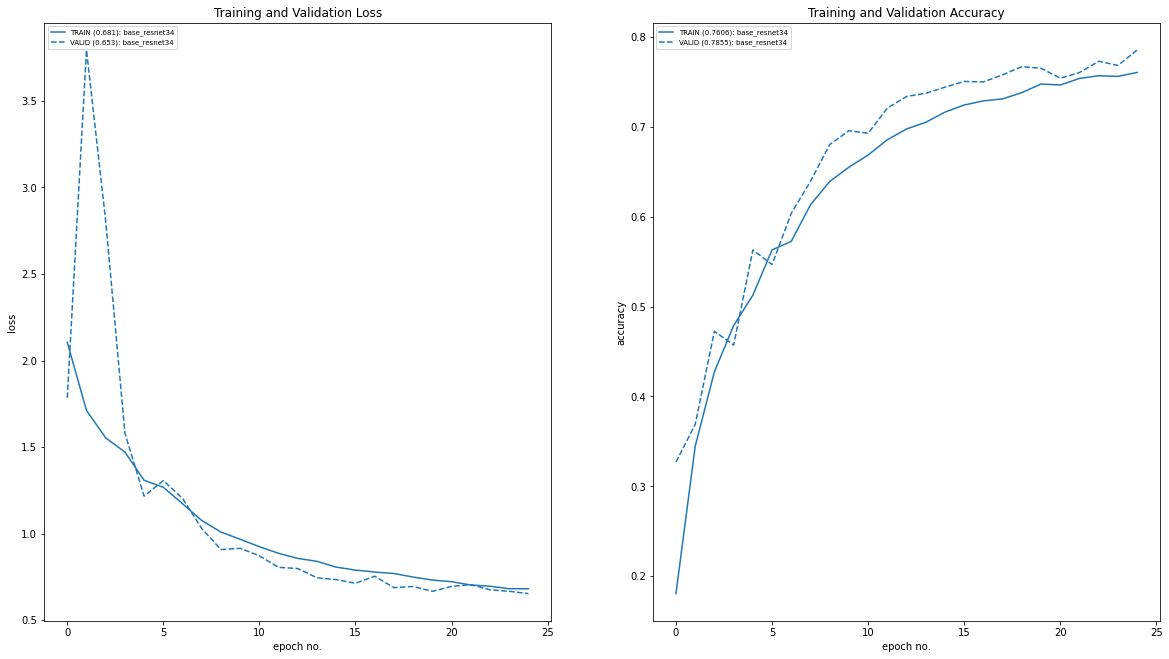

In [15]:
plt.figure(figsize=(20, 11))
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["base_resnet34"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

### Resnet-50

In [16]:
resnet_model_2 = ResNetX(
    resnet_variant=model_parameters["resnet50"], img_channels=3, num_classes=10
).to(device)
print(resnet_model_2)

ResNetX(
  (prep_layer): ResnetPrepBlock(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (layer1): Sequential(
    (0): ResnetBasicBlock(
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 256, kernel_size=(1, 1

In [17]:
summary(resnet_model_2, (1,3, 32,32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetX                                  [1, 10]                   --
├─ResnetPrepBlock: 1-1                   [1, 64, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 16, 16]           128
│    └─ReLU: 2-3                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                    [1, 64, 8, 8]             --
├─Sequential: 1-2                        [1, 256, 8, 8]            --
│    └─ResnetBasicBlock: 2-5             [1, 256, 8, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│ 

In [18]:
optimizer, criterion, metric, early_stopping = model_drivers(
    model=resnet_model_2,
    learning_rate=learning_rate,
    device=device,
    num_classes=num_classes,
    model_name="resnet_model_50.pt",
)

In [19]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        resnet_model_2,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        resnet_model_2,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )


    early_stopping(
        test_losses[-1], resnet_model_2, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


training:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/98 [00:00<?, ?it/s]

Avg Train Loss: 2.6581780156310724 Avg Train Metric: 0.1624181750325524: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.19it/s]


Validation loss decreased (inf --> 3.561638).  Saving model ...
Epoch 1


Avg Train Loss: 2.0339671166575686 Avg Train Metric: 0.29572235078227765: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.28it/s]


Validation loss decreased (3.561638 --> 1.783314).  Saving model ...
Epoch 2


Avg Train Loss: 2.2770822534755784 Avg Train Metric: 0.20274304066385543: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.26it/s]


EarlyStopping counter: 1 out of 5
Epoch 3


Avg Train Loss: 1.9368071324971257 Avg Train Metric: 0.2843927613326481: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.26it/s]


EarlyStopping counter: 2 out of 5
Epoch 4


Avg Train Loss: 1.7551967112385496 Avg Train Metric: 0.3444592840209299: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.31it/s]


Validation loss decreased (1.783314 --> 1.713564).  Saving model ...
Epoch 5


Avg Train Loss: 1.6924924984270213 Avg Train Metric: 0.39085871346142825: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.31it/s]


Validation loss decreased (1.713564 --> 1.573107).  Saving model ...
Epoch 6


Avg Train Loss: 1.5913739958587958 Avg Train Metric: 0.4241159740759402: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.26it/s]


Validation loss decreased (1.573107 --> 1.429786).  Saving model ...
Epoch 7


Avg Train Loss: 1.4713290978451163 Avg Train Metric: 0.4637066825312011: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.32it/s]


Validation loss decreased (1.429786 --> 1.314783).  Saving model ...
Epoch 8


Avg Train Loss: 1.3892838881940257 Avg Train Metric: 0.4942159999390038: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.31it/s]


Validation loss decreased (1.314783 --> 1.288602).  Saving model ...
Epoch 9


Avg Train Loss: 1.3216032580453523 Avg Train Metric: 0.522354889280942: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.35it/s]


Validation loss decreased (1.288602 --> 1.141335).  Saving model ...
Epoch 10


Avg Train Loss: 1.2340041131389385 Avg Train Metric: 0.5496550019906492: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.34it/s]


Validation loss decreased (1.141335 --> 1.094653).  Saving model ...
Epoch 11


Avg Train Loss: 1.164089318440885 Avg Train Metric: 0.5772443170450172: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.33it/s]


Validation loss decreased (1.094653 --> 1.041822).  Saving model ...
Epoch 12


Avg Train Loss: 1.1000953857996025 Avg Train Metric: 0.6035546794229624: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.31it/s]


EarlyStopping counter: 1 out of 5
Epoch 13


Avg Train Loss: 1.0589473058982772 Avg Train Metric: 0.619824835232326: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.33it/s]


Validation loss decreased (1.041822 --> 1.039408).  Saving model ...
Epoch 14


Avg Train Loss: 1.009251901689841 Avg Train Metric: 0.6396266136850629: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.23it/s]


Validation loss decreased (1.039408 --> 0.914908).  Saving model ...
Epoch 15


Avg Train Loss: 0.9724262849408754 Avg Train Metric: 0.6540733308208232: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.22it/s]


Validation loss decreased (0.914908 --> 0.892026).  Saving model ...
Epoch 16


Avg Train Loss: 0.964959125129544 Avg Train Metric: 0.6621840286011599: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.29it/s]


EarlyStopping counter: 1 out of 5
Epoch 17


Avg Train Loss: 0.9283995865559092 Avg Train Metric: 0.6690524287369787: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.28it/s]


EarlyStopping counter: 2 out of 5
Epoch 18


Avg Train Loss: 0.8974315578840217 Avg Train Metric: 0.6794622224204394: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.32it/s]


Validation loss decreased (0.892026 --> 0.815781).  Saving model ...
Epoch 19


Avg Train Loss: 0.8703913080449007 Avg Train Metric: 0.6929587709660433: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.35it/s]


EarlyStopping counter: 1 out of 5
Epoch 20


Avg Train Loss: 0.856585686912342 Avg Train Metric: 0.6995934077671596: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.31it/s]


Validation loss decreased (0.815781 --> 0.798966).  Saving model ...
Epoch 21


Avg Train Loss: 0.8324129806489361 Avg Train Metric: 0.7115028889811769: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.29it/s]


Validation loss decreased (0.798966 --> 0.775389).  Saving model ...
Epoch 22


Avg Train Loss: 0.8188278103361324 Avg Train Metric: 0.7136854511134478: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.33it/s]


EarlyStopping counter: 1 out of 5
Epoch 23


Avg Train Loss: 0.8023590457682707 Avg Train Metric: 0.721705436706543: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.33it/s]


EarlyStopping counter: 2 out of 5
Epoch 24


Avg Train Loss: 0.7849804631301335 Avg Train Metric: 0.7268410172997689: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.31it/s]


EarlyStopping counter: 3 out of 5


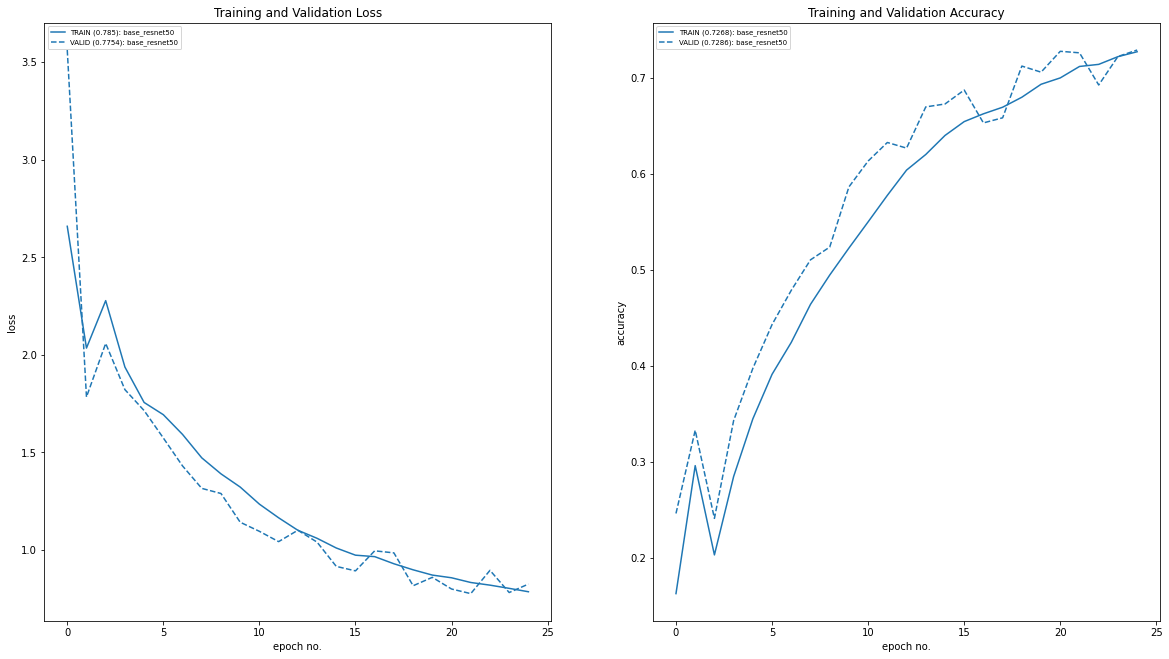

In [20]:
plt.figure(figsize=(20, 11))
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["base_resnet50"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

As we see we are stuck with a constant learning rate , we would like to switch to different optimizer like SGD and also application of One cycle policy and try with RESENT18

In [32]:
resnet_model_new = ResNetX(
    resnet_variant=model_parameters["resnet18"], img_channels=3, num_classes=10
).to(device)
print(resnet_model_new)

ResNetX(
  (prep_layer): ResnetPrepBlock(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (layer1): Sequential(
    (0): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [34]:
optimizer, criterion, metric, early_stopping = model_drivers(
    model=resnet_model_new,
    learning_rate=learning_rate,
    device=device,
    num_classes=num_classes,
    model_name="resnet_model_18_schd.pt",
)

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/100 [00:00<?, ?it/s]

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.06E-02


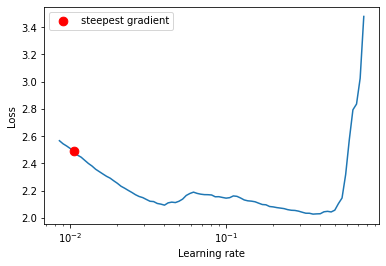

In [35]:
suggested_lr(resnet_model_new, optimizer, criterion, device, 1, 100, train_loader)

In [36]:
suggested_lr = 1.06E-02
print(suggested_lr)

0.0106


Application of One Cycle LR

In [37]:
resnet_model_new = ResNetX(
    resnet_variant=model_parameters["resnet18"], img_channels=3, num_classes=10
).to(device)
print(resnet_model_new)

ResNetX(
  (prep_layer): ResnetPrepBlock(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (layer1): Sequential(
    (0): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [38]:
optimizer, criterion, metric, early_stopping = model_drivers(
    model=resnet_model_new,
    learning_rate=learning_rate,
    device=device,
    num_classes=num_classes,
    model_name="resnet_model_18_schd.pt",
)

In [39]:
scheduler = get_lr_scheduler(
    type="CyclicLR",
    optimizer=optimizer,
    max_lr=suggested_lr,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
    pct_start=5 / epochs,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
)

In [40]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        resnet_model_new,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        resnet_model_new,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )
    # Lr scheduler added
    scheduler.step()
    print(f"Learning rate ahead: {scheduler.get_last_lr()}")

    early_stopping(
        test_losses[-1], resnet_model_new, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


training:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/98 [00:00<?, ?it/s]

Avg Train Loss: 1.7499883187060454 Avg Train Metric: 0.3035064918958411: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 12.67it/s]


Learning rate ahead: [0.00012746012269938652]
Validation loss decreased (inf --> 1.435031).  Saving model ...
Epoch 1


Avg Train Loss: 1.4509653424730107 Avg Train Metric: 0.46263985731163804: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.09it/s]


Learning rate ahead: [0.000148920245398773]
Validation loss decreased (1.435031 --> 1.253979).  Saving model ...
Epoch 2


Avg Train Loss: 1.3238208172272663 Avg Train Metric: 0.5115640382377469: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.13it/s]


Learning rate ahead: [0.00017038036809815952]
Validation loss decreased (1.253979 --> 1.172609).  Saving model ...
Epoch 3


Avg Train Loss: 1.2219831955676177 Avg Train Metric: 0.5548018277907858: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 12.58it/s]


Learning rate ahead: [0.00019184049079754603]
Validation loss decreased (1.172609 --> 1.080565).  Saving model ...
Epoch 4


Avg Train Loss: 1.1474376393824208 Avg Train Metric: 0.5883954471471359: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 12.38it/s]


Learning rate ahead: [0.00021330061349693252]
Validation loss decreased (1.080565 --> 1.025082).  Saving model ...
Epoch 5


Avg Train Loss: 1.0891404261394424 Avg Train Metric: 0.6101938540838203: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 12.33it/s]


Learning rate ahead: [0.00023476073619631903]
Validation loss decreased (1.025082 --> 0.963827).  Saving model ...
Epoch 6


Avg Train Loss: 1.0288979088773533 Avg Train Metric: 0.6335346789992585: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.15it/s]


Learning rate ahead: [0.0002562208588957055]
Validation loss decreased (0.963827 --> 0.943857).  Saving model ...
Epoch 7


Avg Train Loss: 0.9924381442215978 Avg Train Metric: 0.6421874506132943: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.12it/s]


Learning rate ahead: [0.00027768098159509203]
EarlyStopping counter: 1 out of 5
Epoch 8


Avg Train Loss: 0.9529131024467702 Avg Train Metric: 0.6597398112014848: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:08<00:00, 12.17it/s]


Learning rate ahead: [0.00029914110429447854]
Validation loss decreased (0.943857 --> 0.914400).  Saving model ...
Epoch 9


Avg Train Loss: 0.9229478580611092 Avg Train Metric: 0.6742690825948909: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 12.69it/s]


Learning rate ahead: [0.000320601226993865]
Validation loss decreased (0.914400 --> 0.847724).  Saving model ...
Epoch 10


Avg Train Loss: 0.8886657253820069 Avg Train Metric: 0.6841840366927945: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.18it/s]


Learning rate ahead: [0.0003420613496932515]
EarlyStopping counter: 1 out of 5
Epoch 11


Avg Train Loss: 0.8593950618286522 Avg Train Metric: 0.6909253214086805: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.19it/s]


Learning rate ahead: [0.00036352147239263803]
Validation loss decreased (0.847724 --> 0.827421).  Saving model ...
Epoch 12


Avg Train Loss: 0.8364352115562984 Avg Train Metric: 0.702306229849251: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.12it/s]


Learning rate ahead: [0.00038498159509202455]
Validation loss decreased (0.827421 --> 0.771692).  Saving model ...
Epoch 13


Avg Train Loss: 0.8062743082338449 Avg Train Metric: 0.716852284207636: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.15it/s]


Learning rate ahead: [0.00040644171779141106]
EarlyStopping counter: 1 out of 5
Epoch 14


Avg Train Loss: 0.7863171210094374 Avg Train Metric: 0.7199199108444915: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.19it/s]


Learning rate ahead: [0.0004279018404907976]
EarlyStopping counter: 2 out of 5
Epoch 15


Avg Train Loss: 0.7658492138191145 Avg Train Metric: 0.7272553997380393: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.18it/s]


Learning rate ahead: [0.0004493619631901841]
EarlyStopping counter: 3 out of 5
Epoch 16


Avg Train Loss: 0.7487817747252328 Avg Train Metric: 0.7398742425198458: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.14it/s]


Learning rate ahead: [0.0004708220858895706]
EarlyStopping counter: 4 out of 5
Epoch 17


Avg Train Loss: 0.7439601834939451 Avg Train Metric: 0.7360713536642036: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.13it/s]


Learning rate ahead: [0.0004922822085889571]
Validation loss decreased (0.771692 --> 0.735233).  Saving model ...
Epoch 18


Avg Train Loss: 0.7161330532054512 Avg Train Metric: 0.7505851156857549: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.16it/s]


Learning rate ahead: [0.0005137423312883436]
Validation loss decreased (0.735233 --> 0.723059).  Saving model ...
Epoch 19


Avg Train Loss: 0.7028151312652899 Avg Train Metric: 0.7503410535199302: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.14it/s]


Learning rate ahead: [0.00053520245398773]
EarlyStopping counter: 1 out of 5
Epoch 20


Avg Train Loss: 0.6910858209035835 Avg Train Metric: 0.7566755286284855: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.14it/s]


Learning rate ahead: [0.0005566625766871165]
Validation loss decreased (0.723059 --> 0.659808).  Saving model ...
Epoch 21


Avg Train Loss: 0.6721241839078008 Avg Train Metric: 0.7627153092501114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.19it/s]


Learning rate ahead: [0.0005781226993865031]
EarlyStopping counter: 1 out of 5
Epoch 22


Avg Train Loss: 0.6634096059263969 Avg Train Metric: 0.7682037377844051: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.25it/s]


Learning rate ahead: [0.0005995828220858896]
EarlyStopping counter: 2 out of 5
Epoch 23


Avg Train Loss: 0.6449881226432567 Avg Train Metric: 0.7713559190837704: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.26it/s]


Learning rate ahead: [0.0006210429447852761]
EarlyStopping counter: 3 out of 5
Epoch 24


Avg Train Loss: 0.6335631548141947 Avg Train Metric: 0.7785764665019755: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:07<00:00, 13.05it/s]


Learning rate ahead: [0.0006425030674846626]
EarlyStopping counter: 4 out of 5


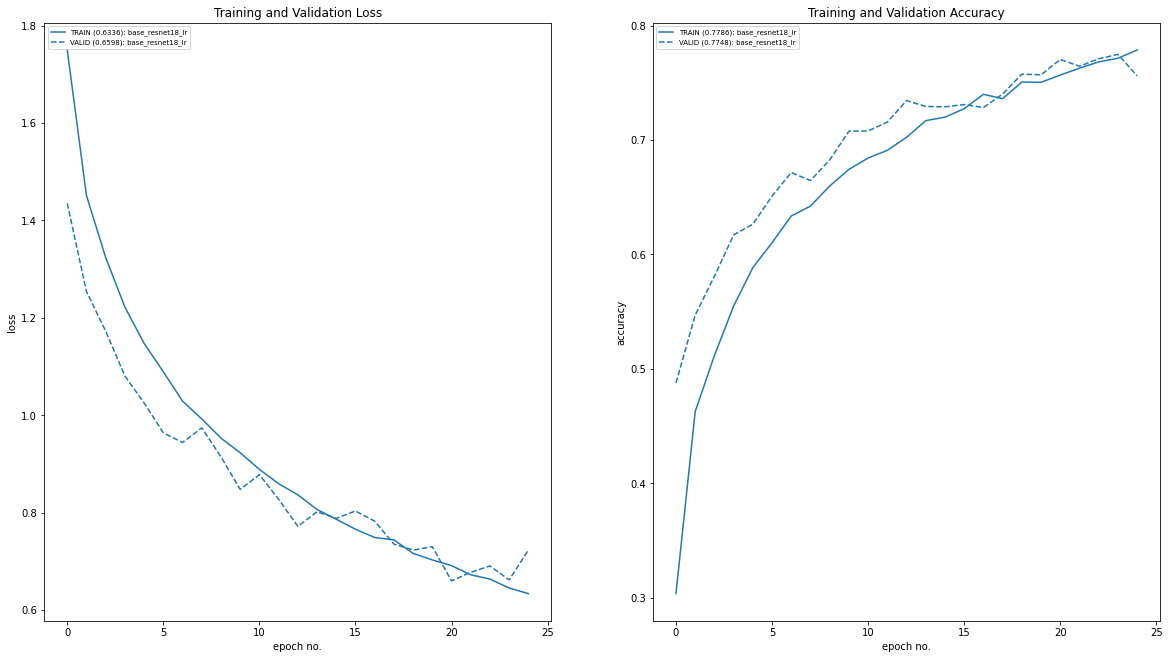

In [41]:
plt.figure(figsize=(20, 11))
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["base_resnet18_lr"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

In [42]:
import torch
from tqdm import tqdm

In [44]:
def eval_module(
    model: torch.nn.Module,
    device: torch.device,
    test_dataloader: torch.utils.data.DataLoader,
):
    """
    Evaluate the model on the test set.
    """
    # setting model to eval mode
    model.eval()
    pbar = tqdm(test_dataloader, desc="Evaluation", dynamic_ncols=True)

    # batch metrics
    predictions = []
    actuals = []

    with torch.inference_mode():
        for idx, (data, label) in enumerate(pbar):
            data, label = data.to(device), label.to(device)
            actuals.append(label)
            # predictions
            preds = model(data)
            # print(preds.shape)
            # print(label.shape)

            # metric calc
            preds = torch.argmax(preds, dim=1)

            predictions.append(preds)

    return (
        torch.cat(actuals, dim=0).cpu().numpy(),
        torch.cat(predictions, dim=0).cpu().numpy(),
    )

In [45]:
# get dataloader for data batching
dataloader_args = dict(
    shuffle=False,
    batch_size=1,
)

# batch loading
_, _, evaldataset, eval_loader = get_data_loader(
    None, test, None, test_transforms, dataloader_args
)

In [47]:
actuals , predictions = eval_module(resnet_model_new, device, eval_loader)

Evaluation:   0%|█▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 12/10000 [00:00<01:26, 115.33it/s]

Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:03<00:00, 156.55it/s]


In [48]:
cmatrix = confusion_matrix(actuals, predictions)
print(classification_report(actuals, predictions, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.82      0.80      0.81      1000
  automobile       0.93      0.77      0.84      1000
        bird       0.57      0.80      0.66      1000
         cat       0.68      0.43      0.53      1000
        deer       0.66      0.83      0.73      1000
         dog       0.71      0.61      0.66      1000
        frog       0.80      0.83      0.82      1000
       horse       0.85      0.81      0.83      1000
        ship       0.87      0.88      0.88      1000
       truck       0.82      0.85      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



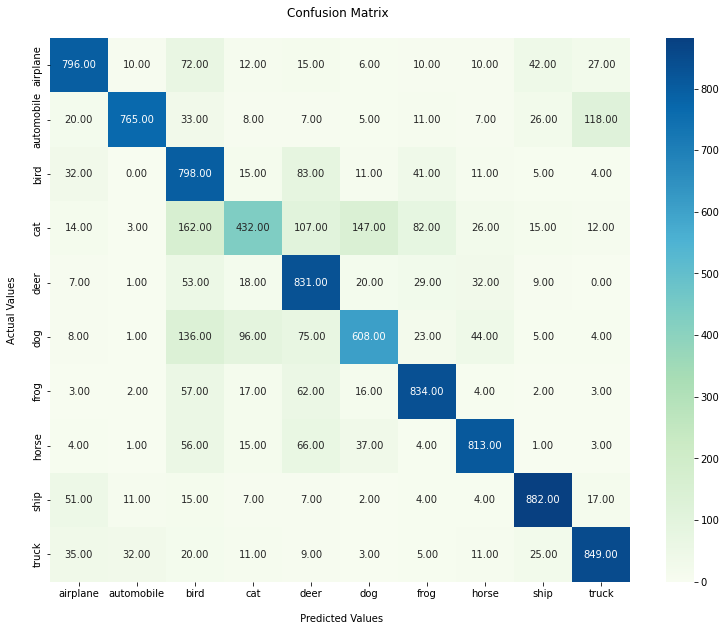

In [49]:
plt.figure(figsize=(13,10))
fx=sns.heatmap(cmatrix, annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(classes)
fx.yaxis.set_ticklabels(classes)
plt.show()

In [50]:
mismatches_idx = np.where(predictions != actuals)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


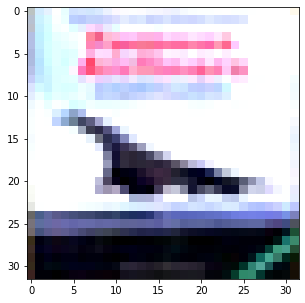

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: airplane and Prediction: ship
6


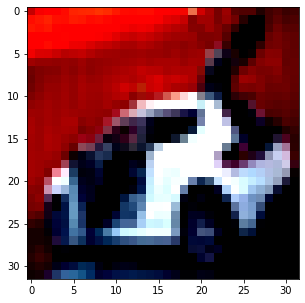

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile and Prediction: cat
9


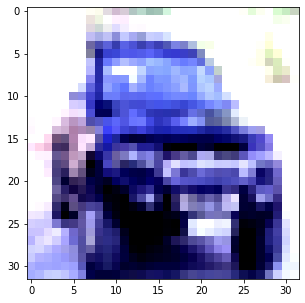

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile and Prediction: truck
12


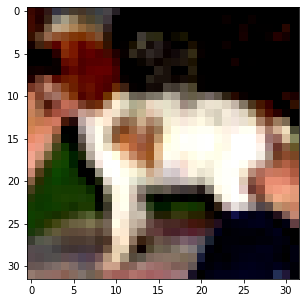

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: dog and Prediction: deer
21


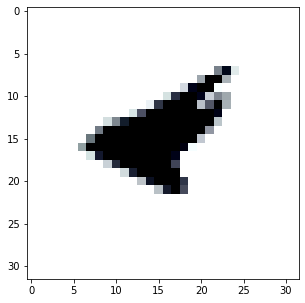

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: airplane and Prediction: bird
24


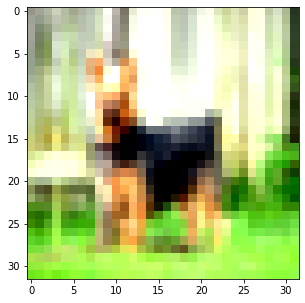

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: dog and Prediction: deer
31


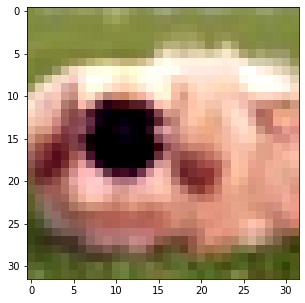

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: dog and Prediction: bird
32


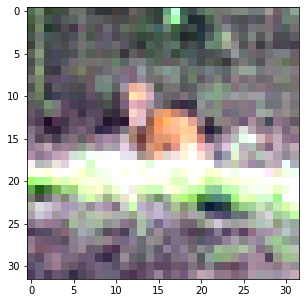

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: deer and Prediction: bird
33


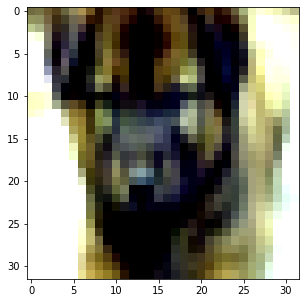

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: dog and Prediction: bird
35


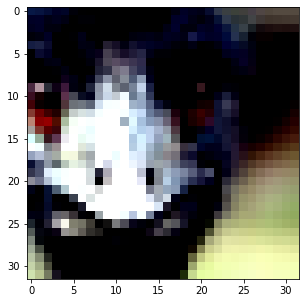

Label: bird and Prediction: cat


In [52]:
for idx in mismatches_idx[0][:10]:
    print(idx)
    plt.figure(figsize=(5, 5))
    img, label = evaldataset[idx]
    imshow(img)
    print(f"Label: {classes[label]} and Prediction: {classes[predictions[idx]]}")
    plt.show()

#### Application of Gradcam - ExplainableAI